# San Francisco Crime Classification
### Exploratory Data Analysis and Predicting the category of crimes that occurred in the city by the bay

From 1934 to 1963, San Francisco was infamous for housing some of the world's most notorious criminals on the inescapable island of Alcatraz.

Today, the city is known more for its tech scene than its criminal past. But, with rising wealth inequality, housing shortages, and a proliferation of expensive digital toys riding BART to work, there is no scarcity of crime in the city by the bay.

From Sunset to SOMA, and Marina to Excelsior, this competition's dataset provides nearly 12 years of crime reports from across all of San Francisco's neighborhoods. Given time and location, you must predict the category of crime that occurred.

What can we learn about the city through visualizations?

In [ ]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
from __future__ import division
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# read in train and test
train = pd.read_csv('train 2.csv')
test = pd.read_csv('test 2.csv')
# combine both for a couple of visualizations
dat = pd.concat([train, test], axis = 0)
train.head()

#### Transform Dates

In [ ]:
train['Dates'] = pd.to_datetime(train.Dates)
train['Day'] = train.Dates.dt.day
train['Month'] = train.Dates.dt.month
train['Minute'] = train.Dates.dt.minute
train['Hour'] = train.Dates.dt.hour
train['Year'] = train.Dates.dt.year
train['Week'] = train.Dates.dt.week
train['MonthDay'] = train.Dates.map(lambda x: x.strftime("%m-%d"))
train['YearDay'] = train.Dates.map(lambda x: x.strftime("%y-%d"))
train['YearMonth'] = train.Dates.map(lambda x: x.strftime("%y-%m"))
train['Event'] = 1

Pluck out the season of each crime

In [ ]:
def get_season(row):
    if row in [5, 6, 7]:
        return 'summer'
    if row in [8, 9, 10]:
        return 'fall'
    if row in [11, 0, 1]:
        return 'winter'
    if row in [2, 3, 4]:
        return 'spring'
    
train['Season'] = train['Month'].map(get_season) 

Combine All Data to show the total number of crimes per day and per month. The spikes in the Year Day are just how the train adn test sets are split

In [ ]:
# we use the combined data of train and test sets just for this illistration
dat['Dates'] = pd.to_datetime(dat.Dates)
dat['Event'] = 1

dat['YearMonth'] = dat.Dates.map(lambda x: x.strftime("%y-%m"))
yearMonth = dat[['Event', 'YearMonth']].groupby(['YearMonth']).count()
yearMonth.columns = ['Crimes']
# rolling mean by year
yearMonth['Rolling Mean'] = pd.rolling_mean(yearMonth.Crimes, 12)

dat['YearDay'] = dat.Dates.map(lambda x: x.strftime("%y-%d"))
yearDay = dat[['Event', 'YearDay']].groupby(['YearDay']).count()
yearDay.columns = ['Crimes']
# rolling mean by 2 weeks
yearDay['Rolling Mean'] = pd.rolling_mean(yearDay.Crimes, 14)

yearDay.plot(figsize = (18, 6))
plt.title('Total Crimes Grouped By Day')
plt.ylabel('Number of Crimes')
plt.tight_layout()

yearMonth.plot(figsize = (18, 6))
plt.title('Total Crimes Grouped By Month')
plt.ylabel('Number of Crimes')
plt.legend()
plt.tight_layout()

## Categories

#### This is the predictor in the dataset
We will only be using the training set from now on later, we will predict this variable, but first we will take a deep look at the `Category` column and the other columns used to predict this one

Look at total count of crimes for each criminal activity

In [ ]:
train.Category.value_counts().plot(kind = 'barh', figsize = (15,10))
plt.title('Crimes By Category')
plt.tight_layout()

Create Kernel Density Plots for each crime type in the dataset to visually show where these crimes occur in the city. First we load in an open street map, so we can later overlay the data on the plot

In [ ]:
# load in map and set coordinates for map
mapdata = np.loadtxt("sf_map_copyright_openstreetmap_contributors.txt")
lon_lat_box = (-122.5247, -122.3366, 37.699, 37.8299)
asp = mapdata.shape[0] * 1.0 / mapdata.shape[1]

# subset to 300000 for time purposes 
fac_train = train.dropna()
fac_train = fac_train[1:300000] 

# seaborn FacetGrid, split by crime Category
g= sns.FacetGrid(fac_train, col = 'Category', col_wrap = 5, size = 6, aspect = 1 / asp)

# show the background map
for ax in g.axes:
    ax.imshow(mapdata, cmap = plt.get_cmap('gray'), 
              extent = lon_lat_box, 
              aspect = asp)
    
# Kernel Density Estimate plot
g.map(sns.kdeplot, 'X', 'Y', clip = clipsize)
plt.tight_layout()

Next we will dive deeper into the categories and the map and show individual crime incidents for the desired category. The draw_map function takes in a dataframe and an optional desired category to subset the search, while the second plot_amount function takes in a dataframe, category, and timeline and produces a line plot showing the number of crimes grouped per desired time interval along with a desired moving average

In [ ]:
from mpl_toolkits.basemap import Basemap

def draw_map(df, subset=None, state_boundries=True, fill_land=False):

    fig = plt.figure(figsize=(20,10))

    # Create a map
    map = Basemap(projection='cyl', resolution = 'h', llcrnrlon = -122.5247, llcrnrlat = 37.699,
                urcrnrlon = -122.3366, urcrnrlat = 37.8299, lat_0=37.752303, lon_0=-122.445576)
    
    # Draw state boundries on the map
    if state_boundries == True:
        map.drawstates()
        
    # Draw the coastlines on the map
#     map.drawcoastlines()

    # Draw country borders on the map
#     map.drawcountries()

    # Fill the land with grey
    if fill_land == True:
        map.fillcontinents(color = '#888888')

    # Draw the map boundaries
#     map.drawmapboundary(fill_color = '#f4f4f4')

    # Define our subset, longitude and latitude points 
    df = df[df['Category'] == subset]
    x, y = map(df['X'].values, df['Y'].values)
    
    # Overlay open street map
    mapdata = np.loadtxt("sf_map_copyright_openstreetmap_contributors.txt")
    lon_lat_box = (-122.5247, -122.3366, 37.699, 37.8299)
    asp = mapdata.shape[0] * 1.0 / mapdata.shape[1]
    plt.imshow(mapdata, extent = lon_lat_box, aspect = asp, cmap=plt.get_cmap('gray'))
    map.plot(x, y, 'bo')

    # Show the map
    plt.show()

In [ ]:
def plot_amount(df, subset, roll_num, group):
    df['Event'] = 1
    df = df[df.Category == subset]

    df = df[['Event', group]].groupby([group]).count()
    df.columns = ['Crimes']
    # rolling mean
    df['Rolling Mean'] = pd.rolling_mean(df.Crimes, roll_num)

    df.plot(figsize = (18, 6))
    plt.title('Total Crimes Grouped By Month')
    plt.ylabel('Number of Crimes')
    plt.tight_layout()

Lets take a look at a few of the individual categories

##### Prostitution

In [ ]:
draw_map(train, 'PROSTITUTION')

In [ ]:
# prostitution grouped my month with 12 month moving average
plot_amount(train, 'PROSTITUTION', 12, 'YearMonth')

##### Suicide

In [ ]:
draw_map(train, 'SUICIDE')

In [ ]:
# suicide grouped by month with 12 month moving average
plot_amount(train, 'SUICIDE', 12, 'YearMonth')

Check if the peak for one of the months is statistically different than the others 

In [ ]:
import scipy.stats as sm

# whats that peak 
suicide_df = train[train.Category == 'SUICIDE']
suicide_aug_2009 = suicide_df[(suicide_df.Year == 2009) & (suicide_df.Month == 8)]
highest_number = suicide_aug_2009[['Month', 'Event']].groupby('Month').count().values

# t test for the peak modeling the samples as a Poisson distribution
num_occ_suicide = suicide_df[['YearMonth', 'Event']].groupby('YearMonth').count().reset_index().Event.values
rvs = sm.poisson.rvs(mu = num_occ_suicide, loc = num_occ_suicide)
t_test = sm.ttest_1samp(rvs, highest_number)
print 'The T-Stat for August 2009 is:', t_test.statistic[0][0]
print 'P-Value for August 2009 is:', t_test.pvalue[0][0], 'which is significant'

##### Drunkenness

In [ ]:
draw_map(train, 'DRUNKENNESS')

In [ ]:
# drunkenness grouped my day with 2 week moving average
plot_amount(train, 'DRUNKENNESS', 14, 'YearDay')

##### Vehicle Theft

In [ ]:
# use kde as scatter plot is too dense
vehicle_theft = train[train.Category == 'VEHICLE THEFT']
lon_lat_box = (-122.5247, -122.3366, 37.699, 37.8299)
clipsize = [[-122.5247, -122.3366],[ 37.699, 37.8299]]


plt.figure(figsize=(20,20 * asp))
ax = sns.kdeplot(vehicle_theft.X, vehicle_theft.Y, clip = clipsize, aspect = 1 / asp)
ax.imshow(mapdata, cmap = plt.get_cmap('gray'), 
              extent = lon_lat_box, aspect = asp)
plt.tight_layout()

In [ ]:
# # vehicle theft grouped my day with 2 week moving average
plot_amount(train, 'VEHICLE THEFT', 14, 'YearDay')

This plot is interesting. The drop around the year 2006 is peculiar, so lets take a deeper look into this category. So with this category, lets look at the Description tag and try to determine what is going on here. This function analyses each description and if the words associated with a stolen vehicle are involved, we assign the new created  column with stolen or not stolen

In [ ]:
def stolen_map(row):
    for item in ['STOLEN','GRAND THEFT','RENTAL']:
        if item in row:
            return 'Stolen'
        else:
            return 'Not Stolen'
        
vehicle_theft['Stolen'] = train.Descript.map(stolen_map)

It looks like there were a lot of vehicle recoveries that were no longer reported after 2006. There were zero 'Not Stolen' vehicles after around 2007 with only a couple in the year 2006 Not Stolen So before when we calculated “vehicle thefts per day” we ended up with twice as many cars being “stolen” prior to 2006. Perhaps this can be determined by a different classification tactic by the police.

In [ ]:
stolen = vehicle_theft[vehicle_theft.Stolen == 'Stolen']
not_stolen = vehicle_theft[vehicle_theft.Stolen != 'Stolen']

ax = not_stolen[['YearDay', 'Event']].groupby('YearDay').count().plot(figsize = (18, 6), 
                                                                 title = 'Not Stolen in VEHICLE THEFT')
stolen[['YearDay', 'Event']].groupby('YearDay').count().plot(figsize = (18, 6), 
                                                                  title = 'Stolen By Day in VEHICLE THEFT', ax = ax)

plt.title('Stolen By Day(Blue) and Not Stolen(Red) in VEHICLE THEFT')
plt.tight_layout()

We can also visuallize this with bar charts to show the types of incidents. As yu can see from this plot that all of 2006 and later consisted of 'stolen' related incidents, while pre 2006 consisted of a wider range of incidents 

In [ ]:
plt.figure(figsize = (18,4))
vehicle_theft['post2006'] = np.where(vehicle_theft.Year >= 2006, 1, 0)

sns.countplot('Descript', hue = 'post2006', data = vehicle_theft)
plt.xticks(rotation=90)
plt.title('Description For Vehicile Theft Pre and Post 2006')
plt.show()

We cna also look at the term `recovered` in the description. It look as the same phenomenal as the stolen category and after 2006 this term must have been changed for another

In [ ]:
vehicle_theft['Recovered'] = vehicle_theft.Descript.map(lambda x: 1 if 'recovered' in x.lower() else 0)
recovered = vehicle_theft[vehicle_theft.Recovered == 1]
recovered[['YearDay', 'Event']].groupby('YearDay').count().plot(figsize = (18, 4), title = 'Recovered in VEHICLE THEFT')
plt.tight_layout()

Lets now take a look at the different type of crimes and classify them into white collar, blue collar, and other crimes. With this we can visualize the different type of areas associated with each type of crime

In [ ]:
white_crime = ["FRAUD", "FORGERY/COUNTERFEITING", "BAD CHECKS" , "EXTORTION", "EMBEZZLEMENT", "SUSPICIOUS OCC",
              "BRIBERY"]

blue_crime = ["VANDALISM", "LARCENY/THEFT", "STOLEN PROPERTY", "ROBBERY", "DRIVING UNDER THE INFLUENCE",
             "DISORDERLY CONDUCT", "LIQUOR LAWS", "VEHICLE THEFT", "ASSAULT", "KIDNAPPING", "TRESPASS", 
             "ARSON", "RECOVERED VEHICLE"]
             
other_crime = ["MISSING PERSON", "RUNAWAY", "FAMILY OFFENSES", "SEX OFFENSES NON FORCIBLE",
             "PORNOGRAPHY/OBSCENE MAT", "WEAPON LAWS", "DRUNKENNESS", "SUICIDE", "TREA",
             "DRUG/NARCOTIC", "SEX OFFENSES FORCIBLE",  "LOITERING"]

def collar_crimes(row):
    for white in white_crime:
        if white in row:
            return 'white collar'
    for blue in blue_crime:
        if blue in row:
            return 'blue collar'
    for other in other_crime:
        if other in row:
            return 'other'
    return 'misc'
        

train['collar'] = train.Category.map(collar_crimes)

Facet Grid with a KDE with each type

In [ ]:
fac_train = train.dropna()
fac_train = fac_train[1:300000] 

g = sns.FacetGrid(fac_train, col = 'collar', col_wrap = 2, size = 4, aspect = 1 / asp)

# Show the background map
for ax in g.axes:
    ax.imshow(mapdata, cmap = plt.get_cmap('gray'), 
              extent = lon_lat_box, 
              aspect = asp)
# Kernel Density Estimate plot
g.map(sns.kdeplot, 'X', 'Y', clip = clipsize)
plt.tight_layout()

Plot the Time interval for the different types of crimes

In [ ]:
white_collar = train[train.collar == 'white collar']
blue_collar = train[train.collar == 'blue collar']
other_collar = train[train.collar == 'other']

ax = white_collar[['YearDay', 'Event']].groupby('YearDay').count().plot(figsize=(18, 4), label = 'white')
blue_collar[['YearDay', 'Event']].groupby('YearDay').count().plot(ax = ax)
other_collar[['YearDay', 'Event']].groupby('YearDay').count().plot(ax = ax)
plt.title('Blue - White Collar, Red - White Collar, Purple - Other')
plt.show()

The category `OTHER OFFENSES` in the predictive category. Other Offenses is broken down by word in this word cloud to get an idea of the keywords contained in the crimes that were not high enough to obtain their own category. The word in the cloud are the words that appear in the Description Column. It looks like most of the `OTHER OFFENSES` are related to trafic violations.

WordCloud of OTHER OFFENSES

In [ ]:
from wordcloud import WordCloud, STOPWORDS

# subset column
other_offense_df = train[train.Category == 'OTHER OFFENSES']
# combine all words and remove commas 
other_offense_words = ' '.join(list(other_offense_df.Descript)).replace(',', '')
# create word cloud
wordcloud = WordCloud(stopwords = STOPWORDS, background_color = 'grey', 
                      width = 1600, height = 800).generate(other_offense_words)
plt.figure(figsize=(14, 10))
plt.imshow(wordcloud)
plt.tight_layout()

## Description
Only in train, so can't be for prediction, but it still can be analysed

In [ ]:
train['GrandTheft'] = train.Descript.map(lambda x: 1 if 'theft' in x.lower() else 0)
print 'Percent of Grand Theft:', train.GrandTheft.sum() / train.shape[0]

# percent charged with some type of grand theft
grand_theft = train[train.GrandTheft == 1]

plt.figure(figsize=(18, 6))
sns.countplot('PdDistrict', hue = 'DayOfWeek', data = grand_theft)
plt.title('Theft Count Per District Per Day of Week')
plt.show()

In [ ]:
def auto_related(row):
    for item in ['AUTO', 'LICENSE', 'AUTOMOBILE', 'VEHICLES', 'TRAFFIC']:
        if item in row:
            return 1
        else:
            return 0
        
train['Automobile'] = train.Descript.map(auto_related)
auto = train[train.Automobile == 1]
print 'Percent in dataset:', train.Automobile.sum() / train.shape[0]

plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
auto.Category.value_counts().plot(kind = 'bar')
plt.subplot(1,2,2)
(auto.DayOfWeek.value_counts() / auto.shape[0]).plot(kind = 'bar')
plt.title('Auto Related Categories')
plt.tight_layout()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vect = TfidfVectorizer(stop_words = 'english')
descript_dtm = vect.fit_transform(train.Descript)

term_df = pd.DataFrame(descript_dtm.toarray())
term_df.columns = vect.get_feature_names()

train_dtm = train.join(term_df)
train_dtm.head()

Function to plot any single term in term frequency dataframe and plot the number of occurances per desired time interval. I choose to plot a few, however there is over 900 terms in this dataframe and anything can be ploted here

In [ ]:
def find_term(term, cat, typ):
    # find similiar words if searched word is not in df, simple way
    similiar_words = [word for word in train_dtm.columns if word.startswith(term[0])]
    if term in term_df.columns:
        # easy way to use tf idf vectorizer for word counter as well
        df = train_dtm[train_dtm[term] > 0]
        # normalized bar plot
        if typ == 'bar':
            if df.shape[0] > 0:
                (df[cat].value_counts() / df.shape[0]).plot(kind = 'bar', 
                                        title = '{}: Number of instances: {}'.format(term.upper(), df.shape[0]))
                plt.ylabel('Percent')
            else:
                print 'empty dataframe, try one of these!'
                print similiar_words
        # line plot 
        else:
            df[[cat, 'Event']].groupby(cat).count().plot(figsize=(18,4))
            plt.title('{}: Number of instances: {}'.format(term.upper(), df.shape[0]))
            plt.tight_layout()   
    else:
        print 'term not in dataframe, try one of these!'
        print similiar_words

Lets look at the trifecta of `Sex`, `Money`, `Drugs` By day of the week

In [ ]:
# lets look at sex, money, and drugs
plt.figure(figsize=(18,4))
plt.subplot(1,3,1)
find_term('sex', 'DayOfWeek', 'bar')
plt.subplot(1,3,2)
find_term('money', 'DayOfWeek', 'bar')
plt.subplot(1,3,3)
find_term('drugs', 'DayOfWeek', 'bar')

And By Year and Month. With these plot youo can definitely see that there is high varity between days of the week(above) and the month and year for these three categories. The `Sex` term seem consistant other than a couple of jumps, however the money realted terms jump heavily after the year 2009

In [ ]:
find_term('sex', 'YearMonth', 'line')

In [ ]:
# big jump after 2009
find_term('money', 'YearMonth', 'line')

In [ ]:
find_term('drugs', 'YearMonth', 'line')

## PD District

This is an interesting category as it is the name of the Police Department District where the crime occurred. First we will plot the count and percent of crimes in each Police District

In [ ]:
plt.figure(figsize=(16,8))

ax = sns.countplot("PdDistrict", data = train, order = [i for i in train.PdDistrict.value_counts().keys()])
plt.title('Bar Plot of District with Percent')
# make twin axis
ax2=ax.twinx()
# switch so count axis is on right, frequency on left
ax2.yaxis.tick_left()
ax.yaxis.tick_right()
# switch the labels over
ax.yaxis.set_label_position('right')
ax2.yaxis.set_label_position('left')
ax2.set_ylabel('Frequency [%]')

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.0 * y / train.shape[0]), (x.mean(), y), 
            ha = 'center', va = 'bottom') 

# fix the frequency range
ax2.set_ylim(0,100)
ax.set_ylim(0,ncount)
ax2.grid(None)

Next the 10 most common Crime Categories based on the Police District. This is a good representation of the combination of the amount and type of crime per district

In [ ]:
ten_most_common = train[train['Category'].isin(train['Category'].value_counts()[:10].index)]
ten_most_crime_by_district = pd.crosstab(ten_most_common.PdDistrict, ten_most_common.Category)
ten_most_crime_by_district.plot(kind = 'barh', figsize=(14, 10), stacked = True, colormap = 'Reds')
plt.title('Disbribution of the City-wide Ten Most Common Crimes in Each District')
plt.tight_layout()

Here we show line plots of each police district normalized by the total amount of crimes per district. We do this so the higher crime areas do not look higher than the lower ones. Thefore all of the districts are all on the same scale and we can really see the highest crime rates per desired time interval.

In [ ]:
# normalized by desired time interval, very jankey way of doing this 
def normilzed_district_plot(cat):
    first_g = train[['PdDistrict', cat, 'Event']].groupby(['PdDistrict', cat]).count().reset_index()
    second_g = first_g.groupby('PdDistrict').sum()
    total_per_district = second_g.Event
    total_dict = dict(total_per_district)

    total_df = pd.DataFrame.from_dict(total_dict.items())
    total_df.columns = ['PdDistrict', 'Count']
    total_df = pd.concat([total_df, total_df, total_df, total_df, total_df, total_df, total_df ,total_df], ignore_index=True) 
    total_df = pd.concat([total_df, total_df, total_df], ignore_index=True)
    total_df = total_df.sort(['PdDistrict']).reset_index()
    total_df.drop('index', inplace = True, axis = 1)
    
    first_g['Norm'] = first_g['Event'] / total_df['Count']
    first_g.pivot(cat, 'PdDistrict', 'Norm').plot(figsize = (18,4))
    plt.title('PdDistrict by {}'.format(cat))
    plt.ylabel('Frequency')
    plt.show()

By hour. Makes sense that the lowest would be in the middle of the night, interesting the peak at about noon

In [ ]:
normilzed_district_plot('Hour')

By Minute. Interesting as most reports are probabily rounded by nearest hour and easy interval

In [ ]:
normilzed_district_plot('Minute')

By Year. And you can see the `Tenderloin` had a big peak between the years 2007 - 2010

In [ ]:
normilzed_district_plot('Year')

## Address

Next is disecting the address column. Here we pick out three things. First if the address contains the world block, second we pick out the ending address like `ST`, or `AV`, or `RD`. And lastly we find the `/` character showing that the crime occurred on a street corner.

In [ ]:
train['Block'] = train.Address.map(lambda x: 1 if 'block' in x.lower() else 0).astype(np.float64)
train['EndAddress'] = train.Address.map(lambda x: x[-2:])
train['Intersection'] = train.Address.map(lambda x: 1 if '/' in x else 0).astype(np.float64)

Interesting that the top 3 categories switched in these two plots of intersection crimes, by having other offensises surpass larceny/theft. And non-criminal pass other when there is the term block in the address

In [ ]:
def plot_subset(row, cat, top):
    df = train[train[row] == 1]
    df[cat].value_counts()[:top].plot(kind = 'bar')
    plt.title('Top {} for {} and {}'.format(top, row.upper(), cat))
    plt.ylabel('Count')
    plt.xlabel('Crime Categories')
    
plt.figure(figsize=(18,4))    
plt.subplot(1,2,1)  
plot_subset('Intersection', 'Category', 10)
plt.subplot(1,2,2)    
plot_subset('Block', 'Category', 10)

Now we can plot the Crimes Percent by ending address. However, not too informative for our purposes, but an interesting visualization. Is there really that many roads labelled `ST` in San Francisco

In [ ]:
end_address = train[['EndAddress', 'Event']].groupby(['EndAddress']).count()
(end_address.Event / train.shape[0]).plot(kind = 'bar', figsize = (14,4))
plt.title('Crimes Percent By Ending Street Address')
plt.tight_layout()

Create Log Odd for Address Field

In [ ]:
# example 
logodds2['800 Block of BRYANT ST'].plot(kind = 'barh', figsize = (10,5))
plt.title('Log Odds for Address')
plt.tight_layout()

### Resolution

This is also not in the test dataset, as it is how the crime incident was resolved. However, a couple interesting things can be seen. First off, over 60% of the crimes, no action was taken. Some lenient cops! 

In [ ]:
(train.Resolution.value_counts() / train.shape[0]).plot(kind = 'barh', figsize = (10,5))
plt.title('Crime Resolutions')
plt.tight_layout()

Next we can look at what Police Districts seemed to take more actions than others. This plot is really interesting as the only police district that took more actions than not is the `TENDERLOIN`. And the amount is not even close here.

In [ ]:
plt.figure(figsize=(14, 6))
train['NoResolution'] = train.Resolution.map(lambda x: 'NoActionTaken' if x == 'NONE' else 'ActionTaken')
sns.countplot('PdDistrict', hue = 'NoResolution', data = train)
plt.title('Action Taken in Crime Per District')
plt.tight_layout()

Now that we see this lets take a little deeper dive into the `TENDERLOIN` police district and find out which crimes are contributing to this. It looks at the are more drugs/narcotics with higher churn rates and less larceny/thefts and other petty thefts that might be let go more often. This police district might be focusing more drug rated incidents than others

In [ ]:
# tenderloin pdDistrict
tenderloin = train[train.PdDistrict == 'TENDERLOIN']
tenderloin = tenderloin.groupby(['Category', 'NoResolution'])['Category'].count().unstack('NoResolution').fillna(0)
tenderloin[['ActionTaken','NoActionTaken']].plot(kind='bar', figsize=(14, 6), title = 'Tenderloin Crimes')

# all other pdDistricts
not_tenderloin = train[train.PdDistrict != 'TENDERLOIN']
not_tenderloin = not_tenderloin.groupby(['Category', 'NoResolution'])['Category'].count().unstack('NoResolution').fillna(0)
not_tenderloin[['ActionTaken','NoActionTaken']].plot(kind='bar', figsize=(14, 6), title = 'Not Tenderloin Crimes')
plt.show()

Next we can try and look at the Juveniles that were atleast book and cited in the dataset

In [ ]:
train['Juvenile'] = train.Resolution.map(lambda x: 1 if 'juvenile' in x.lower() else 0)
# how many issued juveniles in data set
print 'Percent of Juvinile in data that were atleast booked {:.2f}%'.format((train.Juvenile.sum() / train.shape[0])*100)

Although it is not a hug subset of the data it is interesting the the summer break months are lower than the school months

In [ ]:
juvinile = train[train.Juvenile == 1]
juvinile['Event'] = 1

non_juvinile = train[train.Juvenile != 1]
non_juvinile['Event'] = 1

fig, axs = plt.subplots(1,2)

juvinile[['Month', 'Event']].groupby(['Month']).count().plot(kind = 'bar', ax = axs[0], figsize = (12,4), 
                                                            title = 'Juvinile Booked Crimes Per Month')

non_juvinile[['Month', 'Event']].groupby(['Month']).count().plot(kind = 'bar', ax = axs[1],
                                                            title = 'Non Juvinile Booked Crimes Per Month')
plt.tight_layout()

# Prediction

After performing Exploratory Data Analysis and dtermining some important predicotrs for predicting the crime category, it is now time to the perform machine learning pipeline. Note some of this will be the same as above

In [37]:
# first clear variables for memory issues
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
import pandas as pd
import numpy as np

# read in data
train = pd.read_csv('train 2.csv')
test = pd.read_csv('test 2.csv')

# drop columns not in test
train.drop(['Descript', 'Resolution'], axis = 1, inplace = True)

Transfrom Dates

In [3]:
for dat in (train, test):
    dat['Dates'] = pd.to_datetime(dat.Dates)
    dat['Day'] = dat.Dates.dt.day
    dat['Month'] = dat.Dates.dt.month
    dat['Minute'] = dat.Dates.dt.minute
    dat['Hour'] = dat.Dates.dt.hour
    dat['Year'] = dat.Dates.dt.year
    dat['Week'] = dat.Dates.dt.week
    dat.drop(['Dates'], axis = 1, inplace = True)

Add Season 

In [4]:
def get_season_binary(row):
    summer, fall, winter, spring = 0, 0, 0, 0
    if row in [5, 6, 7]:
        summer = 1
    if row in [8, 9, 10]:
        fall = 1
    if row in [11, 0, 1]:
        winter = 1
    if row in [2, 3, 4]:
        spring = 1
    return summer, fall, winter, spring

for dat in (train, test):
    dat['Summer'], dat['Fall'], dat['Winter'], dat['Spring'] = zip(*dat['Month'].apply(get_season_binary))

Address - Add 1 for column if `block` occurs in address and add 1 if it is at an intersection

In [5]:
for dat in (train, test):
    dat['Block'] = dat.Address.map(lambda x: 1 if 'block' in x.lower() else 0).astype(np.float64)
    dat['Intersection'] = dat.Address.map(lambda x: 1 if '/' in x else 0).astype(np.float64)

One Hot Encoding - Dummy Variables for `DayOfWeek` and `PdDistrict`. I have always liked using pandas get_dummies method over a sklearn implementations

In [6]:
dummy_vars = ['PdDistrict', 'DayOfWeek']

for dummy in dummy_vars:
    dummies = pd.get_dummies(train[dummy])
    train = train.join(dummies)
    dummies = pd.get_dummies(test[dummy])
    test = test.join(dummies)

Drop Address and recently created dummy varibales fields 

In [7]:
for dat in (train, test):
    dat.drop(['DayOfWeek', 'PdDistrict'], axis = 1, inplace = True)
    dat.drop(['Address'], axis = 1, inplace = True)

Transform `Category` field to numeric integers, just another way of doing LabelEncoder from sklearn with a 1 to 1 mapping

In [8]:
ordered_crimes = train['Category'].value_counts().index.order()
map_values_dic = pd.Series(range(0, len(ordered_crimes)), index = ordered_crimes).to_dict()

train['Category'] = train['Category'].map(map_values_dic)

Split data into X without the independant variable, y the independant variable, and final test (not to be used till the end) while droping the `Id` column

In [9]:
X = train.copy()
y = X.pop('Category').values
X = X.values
test = test.drop('Id', axis = 1).copy().values

### Modeling Time

Split the data into training and testing sets from the original training set

In [10]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 100)
print X_train.shape, X_test.shape

(658536, 31) (219513, 31)


Simple classifier function that in a desired classifier and optional probability paramater if predicted probabilities are desired. We will fit the classifier, predict with the classifier and we will print out both the classification accuracy (number of correctly predicted categories divided by the total number) and the log loss (negitive expected log probability) in terms of using predicted probabilities.

In [11]:
from sklearn.metrics import log_loss, accuracy_score

def simple_classifier(clf, probability=False):
    
    clf.fit(X_train, y_train)
    
    if probability:
        pred_train = clf.predict_proba(X_train)
        pred_test = clf.predict_proba(X_test)
    else:
        pred_train = clf.predict(X_train)
        pred_test = clf.predict(X_test) 

    # for the normal person, classification accuracy 
    clf_train = clf.score(X_train, y_train)
    clf_test = clf.score(X_test, y_test)
    print '{} train/test classification accuracies: {:.3f}/{:.3f}'.format(
        clf.__class__.__name__, clf_train, clf_test)

    # for the statistician, log loss - negative expected log probability
    # -log P(yt|yp) = -(yt log(yp) + (1 - yt) log(1 - yp))
    clf_train_logloss = log_loss(y_train, pred_train)
    clf_test_logloss = log_loss(y_test, pred_test)
    print '{} train/test log los:s {:.3f}/{:.3f}'.format(
        clf.__class__.__name__, clf_train_logloss, clf_test_logloss)

Simple Logistic Regression with a couple of hyperparamaters to reduce the complexity of the model, just to get an idea of what we are dealing with here. Here, it is obvious that a single linear separator is not going to be the answer to such a problem.

In [12]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(penalty = 'l2', C = 0.01, 
                          random_state = 100)

simple_classifier(log_reg, probability = True)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=100, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Grid Search to find the best C parameter for model complexity, the Inverse of regularization strength with L2. We then can use this found parameter later.

In [1]:
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression

param_grid = {
    'C' : [1, 0.1, 0.01, 0.001]
}

clf = LogisticRegression(penalty = 'l2')

grid = GridSearchCV(clf, param_grid, cv = 3, scoring = 'log_loss')
grid.fit(X_train, y_train)

Next I would try a Support Vector Machine, however with its O(n*3) runtime, it would not be reasonable for my purposes, especially if I need to use parameter tuning with grid search, randomized grid search would help but still way too computationally expensive. So lets try an Simple Decision Tree that might work better with our type of data.

In [13]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion = 'entropy', 
                              max_depth = None)

simple_classifier(tree, probability = True)

DecisionTreeClassifier train/test classification accuracies: 0.883/0.242
DecisionTreeClassifier train/test log los:s 0.180/25.421


Now lets do some parameter tuning and visualizing for our Decision Tree Classifier. Here we compute the traing and testing scores for each n_estimator with cross validation, by default StratifiedKFold is used for multiclass classification. Next we will plot the plot the accuracy scores with a confidene interval. Here we can tell that the best max_depth is 10. Plotting the validation curve can be a useful trick to determine rather than using grid search.

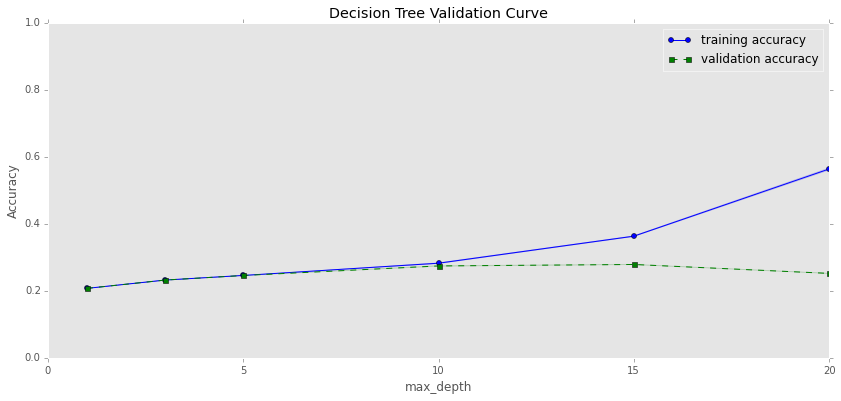

In [20]:
from sklearn.learning_curve import validation_curve
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
%matplotlib inline
from __future__ import division
import warnings
warnings.filterwarnings('ignore')

plt.figure(figsize = (14, 6))

# initialize random forest
tree = DecisionTreeClassifier()
# set param range for n_estimators
param_range = [1, 3, 5, 10, 15, 20]

# create training / testing scores for n_estimators with cross validation
train_scores, test_scores = validation_curve(
                estimator = tree, 
                X = X_train, 
                y = y_train, 
                param_name = 'max_depth', 
                param_range = param_range,
                cv = 3,
                scoring = 'accuracy')

# get mean and std for scores
train_mean = np.mean(train_scores, axis = 1)
train_std = np.std(train_scores, axis = 1)
test_mean = np.mean(test_scores, axis = 1)
test_std = np.std(test_scores, axis = 1)

# plot training points
plt.plot(param_range, train_mean, 
         color = 'blue', marker = 'o', 
         markersize = 5, label = 'training accuracy')

# plot training confidence intervals
plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha = 0.15,
                 color = 'blue')

# plot testing points
plt.plot(param_range, test_mean, 
         color = 'green', linestyle = '--', 
         marker = 's', markersize = 5, 
         label = 'validation accuracy')

# plot testing confidence intervals
plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha = 0.15, color = 'green')

plt.grid()
plt.legend()
plt.title('Decision Tree Validation Curve')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1.0])
plt.show()

Now lets combine some trees with a built in ensemble classifier with a Random Forest

In [12]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 50, random_state = 100)

simple_classifier(rf, probability = True)

RandomForestClassifier train/test classification accuracies: 0.883/0.308
RandomForestClassifier train/test log los:s 0.461/6.371


The king of Ensembles, Voting Classifier. Weighted Majority Vote based on class probabilities. This will allows us to combine different classification algorithms associated with the individual weights of each classifier. It then becomes a good meta-classifier that balances out individual classifiers weaknesses

In [22]:
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.pipeline import _name_estimators
import operator


class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, classifiers, vote = 'classlabel', weights = None):

        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
       
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("vote must be 'probability' or 'classlabel'"
                             "; got (vote=%r)"
                             % vote)

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('Number of classifiers and weights must be equal'
                             '; got %d weights, %d classifiers'
                             % (len(self.weights), len(self.classifiers)))

        # Use LabelEncoder to ensure class labels start with 0, which
        # is important for np.argmax call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):

        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' vote

            #  Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T

            maj_vote = np.apply_along_axis(
                                      lambda x:
                                      np.argmax(np.bincount(x,
                                                weights=self.weights)),
                                      axis=1,
                                      arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):

        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
            return out

Here we use the classifers we have previously tried alone. So we use a Logistic Regression, Random Forest, and Decision Classifier and use the majority voting technique to evaluate the new classifer and see if we can improve on our basic models.

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import log_loss

clf1 = LogisticRegression(penalty = 'l2', 
                          C = 0.01, 
                          random_state = 100)

clf2 = RandomForestClassifier(n_estimators = 50, 
                              random_state = 100)

clf3 = DecisionTreeClassifier(max_depth = 10)

mv_clf = MajorityVoteClassifier(
                classifiers=[clf1, clf2, clf3], vote = 'probability')

mv_clf.fit(X_train, y_train)
pred_train = mv_clf.predict_proba(X_train)
pred_test = mv_clf.predict_proba(X_test)

clf_train = mv_clf.score(X_train, y_train)
clf_test = mv_clf.score(X_test, y_test)
print 'Voting Classifier train/test classification accuracies: {:.3f}/{:.3f}'.format(clf_train, clf_test)

clf_train_logloss = log_loss(y_train, pred_train)
clf_test_logloss = log_loss(y_test, pred_test)
print 'Voting Classifier train/test log loss: {:.3f}/{:.3f}'.format(clf_train_logloss, clf_test_logloss)

Voting Classifier train/test classification accuracies: 0.806/0.319
Voting Classifier train/test log loss: 1.235/2.323


Lastly we can try the king of all classification techniques, XGBoost

In [32]:
import xgboost as xgb

param_grid = {'objective': 'multi:softprob', 'num_class': len(np.unique(y_train))}

X_train_xgb = xgb.DMatrix(X_train, y_train)
X_test_xgb = xgb.DMatrix(X_test)

xgb = xgb.train(param_grid, X_train_xgb, 20)

pred_train = xgb.predict(X_train_xgb)
pred_test = xgb.predict(X_test_xgb)

# print 'Testing Set Log Loss:', log_loss(y_test, pred) # 0.51542415268
xgb_train_logloss = log_loss(y_train, pred_train)
xgb_test_logloss = log_loss(y_test, pred_test)
print 'XGBoost train/test log loss: {:.3f}/{:.3f}'.format(xgb_train_logloss, xgb_test_logloss)

Voting Classifier train/test log los:s 2.289/2.325


#### Fitting All Training Data

Train the Weighted Majority Vote ensemble method on all of the training data

In [24]:
# run on all training data
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import log_loss

clf1 = LogisticRegression(penalty = 'l2', 
                          C = 0.01, 
                          random_state = 100)

clf2 = RandomForestClassifier(n_estimators = 50, 
                              random_state = 100)

clf3 = DecisionTreeClassifier(max_depth = 10)

mv_clf = MajorityVoteClassifier(
                classifiers=[clf1, clf2, clf3], vote = 'probability')

mv_clf.fit(X, y)
pred_train = mv_clf.predict_proba(X)
pred = mv_clf.predict_proba(test)

clf_train = mv_clf.score(X, y)
print 'Voting Classifier classification accuracies with all training data: {:.3f}'.format(
                                                                clf_train)
clf_train_logloss = log_loss(y, pred_train)
print 'Voting Classifier log loss with all training data: {:.3f}'.format(
                                                                clf_train_logloss)

Voting Classifier classification accuracies with all training data: 0.783
Voting Classifier log loss with all training data: 1.252


In [25]:
import csv
import gzip

# Create submission to kaggle
i = 0

with gzip.open('crimesEDA5.csv.gz', 'wt') as outf:
    fo = csv.writer(outf, lineterminator='\n')
    fo.writerow(['Id'] + list(ordered_crimes))
    for i, pr in enumerate(pred):
        fo.writerow([i] + list(pr))

Train a xgboost on all of the training data. This results in a Multi-Class Loss of 2.32902 on the withheld Kaggle test set, 72nd of 1077 at the time of submission

In [ ]:
import xgboost as xgb

param_grid = {'objective': 'multi:softprob', 'num_class': len(np.unique(y))}

X_train_xgb = xgb.DMatrix(X, y)
X_test_xgb = xgb.DMatrix(X_test)

xgb = xgb.train(param_grid, X_train_xgb, 20)

pred_train = xgb.predict(X)
pred = xgb.predict(X_test_xgb)

xgb_train_logloss = log_loss(y, pred_train)
print 'XGBoost log loss with all training data: {:.3f}'.format(xgb_train_logloss)

Create submission to kaggle

In [ ]:
import csv
import gzip

# Create submission to kaggle
i = 0

with gzip.open('crimesEDA4.csv.gz', 'wt') as outf:
    fo = csv.writer(outf, lineterminator='\n')
    fo.writerow(['Id'] + list(ordered_crimes))
    for i, pr in enumerate(pred):
        fo.writerow([i] + list(pr))